# AQMS Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
tensor([1.], device='mps:0')


## Load Dataset

In [2]:
data = pd.read_csv("dataset/Indeks Standar Pencemar Udara di Provinsi DKI Jakarta 2021.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data = data[['co']]

data

,co
tanggal,
2021-01-01,29
2021-01-02,38
2021-01-03,25
2021-01-04,24
2021-01-05,24
...,...
2021-12-27,23
2021-12-28,16
2021-12-29,15


In [3]:
data.isnull().sum()

co    0
dtype: int64

## Time Plot

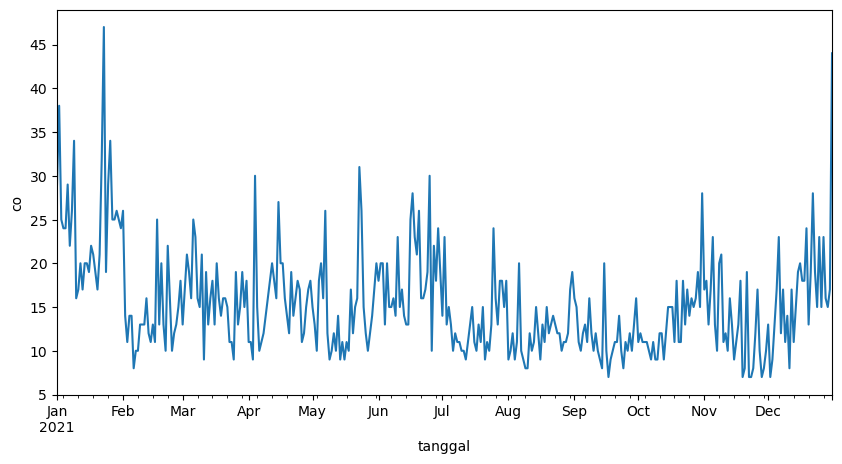

In [4]:
data["co"].plot(figsize = (10,5))
plt.ylabel("co")
plt.show()

## Decomposition

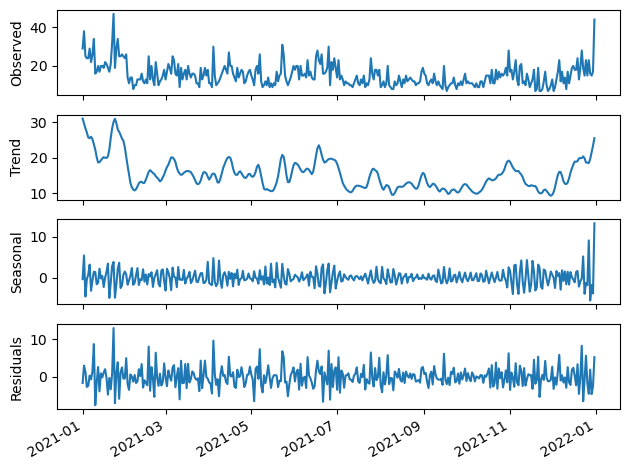

In [5]:
advanced_decomposition = STL(data["co"], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## Modeling 1

In [6]:
baseline = data[['co']].copy(deep=True)
baseline['prev_co'] = baseline['co'].shift(1)
baseline.drop(index=baseline.index[0], inplace=True)
baseline['difference'] = baseline['co'] - baseline['prev_co']
baseline['square_error'] = baseline['difference'] ** 2
# baseline.head(2)

square_error = baseline['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

Square Error of the Naive Approach is 33.382


In [7]:
input_data = data

targets = data['co'].values
T = 30                    # jumlah timestep yang digunakan untuk prediksi
D = input_data.shape[1]   # jumlah dimensi input
N = len(input_data) - T   # jumlah data yang dapat menjadi output prediksi

In [8]:
# menentukan jumlah train_size
train_size = int(len(input_data) * 0.65)

# normalisasi input
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
    X_train[t, :, :] = input_data[t:t+T]
    y_train[t] = (targets[t+T])

X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
    t = i + train_size
    X_test[i, :, :] = input_data[t:t+T]
    y_test[i] = (targets[t+T])

# ubah tipe data menjadi tensor
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        self.M = hidden_dim
        self.L = layer_dim

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True)
    
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
    
        # hidden state dan cell state
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        return out

In [10]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(1, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [11]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=200):

    # loss dan optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # backpropagation
        loss.backward()
        optimizer.step()

        # train loss
        train_losses[epoch] = loss.item()

        # test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()

        if (epoch + 1) % 100 == 0:
            print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

    return train_losses, test_losses

In [12]:
# pindahkan ke GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model, 0.01, X_train, y_train, X_test, y_test, epochs=70)

### Plot Training Result

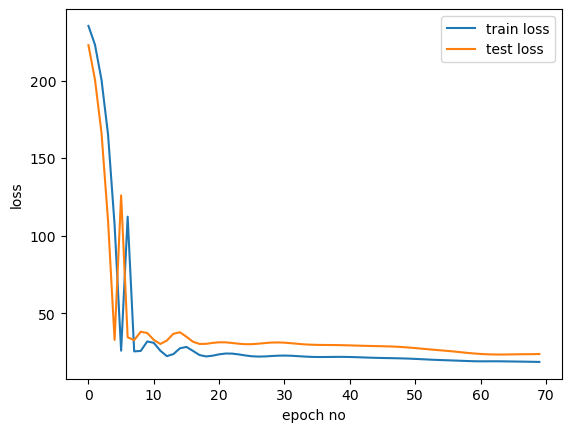

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

### Plot Prediction Performance

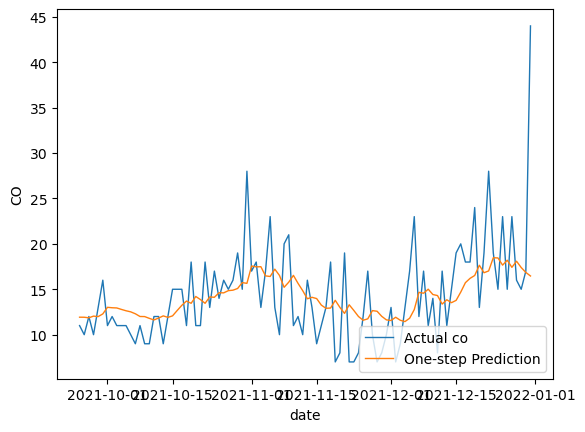

In [14]:
# cek predikti untuk 1 step atau 1 hari
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
    input_ = X_test[i].reshape(1, T, D)
    p = model(input_)[0,0].item()

    test_predictions.append(p)

plot_len = len(test_predictions)
plot_df = data[['co']].copy(deep=True)

plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
# plot_df.set_index('dt', inplace=True)

plt.plot(plot_df['co'], label='Actual co', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('CO')
plt.legend(loc='lower right')
plt.show()

In [17]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
# print(f'Mean square error is: {err:.3f}')

In [16]:
mse = mse(test_target, test_predictions)

print(f'Mean Squared Error on test set: {mse}')

Mean Squared Error on test set: 23.63800561119124


### Plot Error Distribution

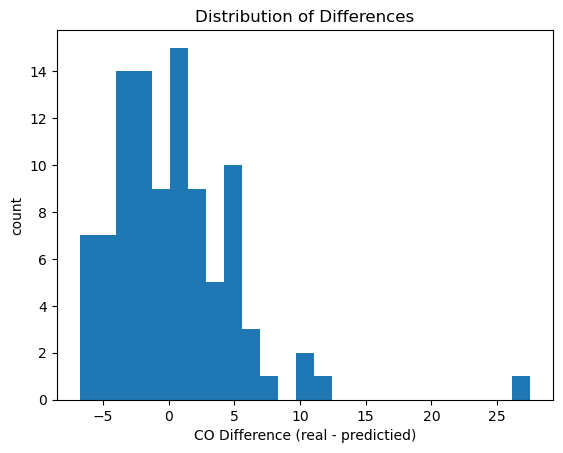

In [18]:
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('CO Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')
plt.show()

## Modeling 2

In [122]:
# normalisasi data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

T = 30  
X, y = [], []
for i in range(len(data) - T):
    X.append(data[i:i + T])
    y.append(data[i + T])
X = np.array(X)
y = np.array(y)

# split train dan test
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ubah menjadi tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [123]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500

In [124]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())
    y_pred = np.concatenate(y_pred)

y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

Epoch [100/500], Loss: 0.0044
Epoch [200/500], Loss: 0.0113
Epoch [300/500], Loss: 0.0052
Epoch [400/500], Loss: 0.0058
Epoch [500/500], Loss: 0.0022


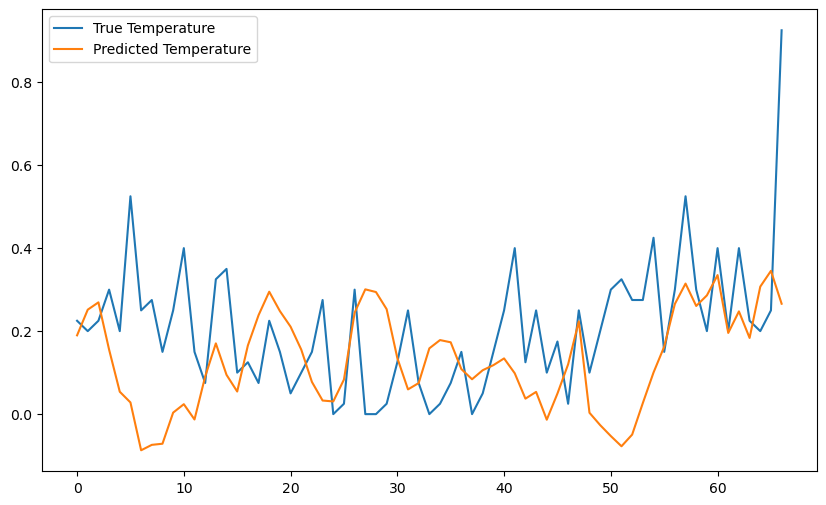

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.legend()
plt.show()

In [126]:
mse = mse(y_test, y_pred)

print(f'Mean Squared Error on test set: {mse}')

TypeError: 'numpy.float64' object is not callable